In [1]:
# EE6350 - Artificial Intelligence Project

# Group Members: Kithurshika K   EG/2020/4023
#                Nevaashahan T.  EG/2020/4098
#                Sivakkanth K    EG/2020/4220
#                Thananchayan T  EG/2020/4227

In [2]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# Set parameters
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10


In [4]:
# Literature Survey
"""
The field of computer vision has seen significant advancements with the development of Convolutional Neural Networks (CNNs).
Several studies have demonstrated the effectiveness of CNNs in image classification tasks.

In the context of medical image analysis, CNNs have been particularly successful. The use of data augmentation, transfer 
learning, and ensembling techniques have further enhanced the performance of CNNs in medical imaging applications.

This project builds on these advancements by implementing a CNN to classify images from a custom dataset, aiming to achieve 
high accuracy in distinguishing between different categories of images. We compare our results with the baselines established 
in the aforementioned studies to evaluate the efficacy of our approach.
"""

'\nThe field of computer vision has seen significant advancements with the development of Convolutional Neural Networks (CNNs).\nSeveral studies have demonstrated the effectiveness of CNNs in image classification tasks.\n\nIn the context of medical image analysis, CNNs have been particularly successful. The use of data augmentation, transfer \nlearning, and ensembling techniques have further enhanced the performance of CNNs in medical imaging applications.\n\nThis project builds on these advancements by implementing a CNN to classify images from a custom dataset, aiming to achieve \nhigh accuracy in distinguishing between different categories of images. We compare our results with the baselines established \nin the aforementioned studies to evaluate the efficacy of our approach.\n'

In [5]:
# Dataset Description
"""
The dataset used in this project is the HAM10k images dataset, Human Against Machine with 10,000 Training Images, which is 
freely available. The dermoscopic images in the HAM10k dataset have been curated and normalized in terms of luminosity, 
colors, resolution, etc. The actual diagnosis was validated by histopathology (a.k.a. source of truth) in more than 50 percent 
of the cases, which is twice more than the previously available skin lesion datasets. The rest of the lesions’ diagnosis was 
based on a consensus of dermatologists.

Instead of trying to classify seven skin lesions with a highly imbalanced dataset, this project simplifies the task to the 
diagnosis of Melanoma vs. Not Melanoma. The dataset categories are summarized into two groups, resulting in an imbalanced 
dataset with:
- 1,113 Melanoma images
- 8,902 Not Melanoma images

To balance the dataset, data augmentation is applied to the Melanoma group, increasing the number of images to be similar to 
the Not Melanoma group. Data augmentation techniques expose the model to various modifications of an image, allowing it to 
generalize better. After augmentation, the dataset becomes balanced with:
- 8,903 Melanoma images
- 8,902 Not Melanoma images

Details about the augmentation process can be found at HIStalk. A Comparative Study of Neural Network Architectures for 
Lesion Segmentation and Melanoma Detection was published in April 2020, using this dataset for melanoma classification 
comparison between several image analysis NN architectures.
"""

'\nThe dataset used in this project is the HAM10k images dataset, Human Against Machine with 10,000 Training Images, which is \nfreely available. The dermoscopic images in the HAM10k dataset have been curated and normalized in terms of luminosity, \ncolors, resolution, etc. The actual diagnosis was validated by histopathology (a.k.a. source of truth) in more than 50 percent \nof the cases, which is twice more than the previously available skin lesion datasets. The rest of the lesions’ diagnosis was \nbased on a consensus of dermatologists.\n\nInstead of trying to classify seven skin lesions with a highly imbalanced dataset, this project simplifies the task to the \ndiagnosis of Melanoma vs. Not Melanoma. The dataset categories are summarized into two groups, resulting in an imbalanced \ndataset with:\n- 1,113 Melanoma images\n- 8,902 Not Melanoma images\n\nTo balance the dataset, data augmentation is applied to the Melanoma group, increasing the number of images to be similar to \nthe 

In [6]:
# Loading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 17805 files belonging to 2 classes.


In [7]:
class_names = dataset.class_names
print("Class names:", class_names)

Class names: ['Melanoma', 'NotMelanoma']


In [8]:
# Exploratory Data Analysis (EDA)
print("Total number of batches:", len(dataset))
print("Total number of images:", 557 * 32)  # Update this based on actual dataset size


Total number of batches: 557
Total number of images: 17824


In [9]:
for image_batch, labels_batch in dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", labels_batch.numpy())

Image batch shape: (32, 256, 256, 3)
Label batch shape: [1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 1]


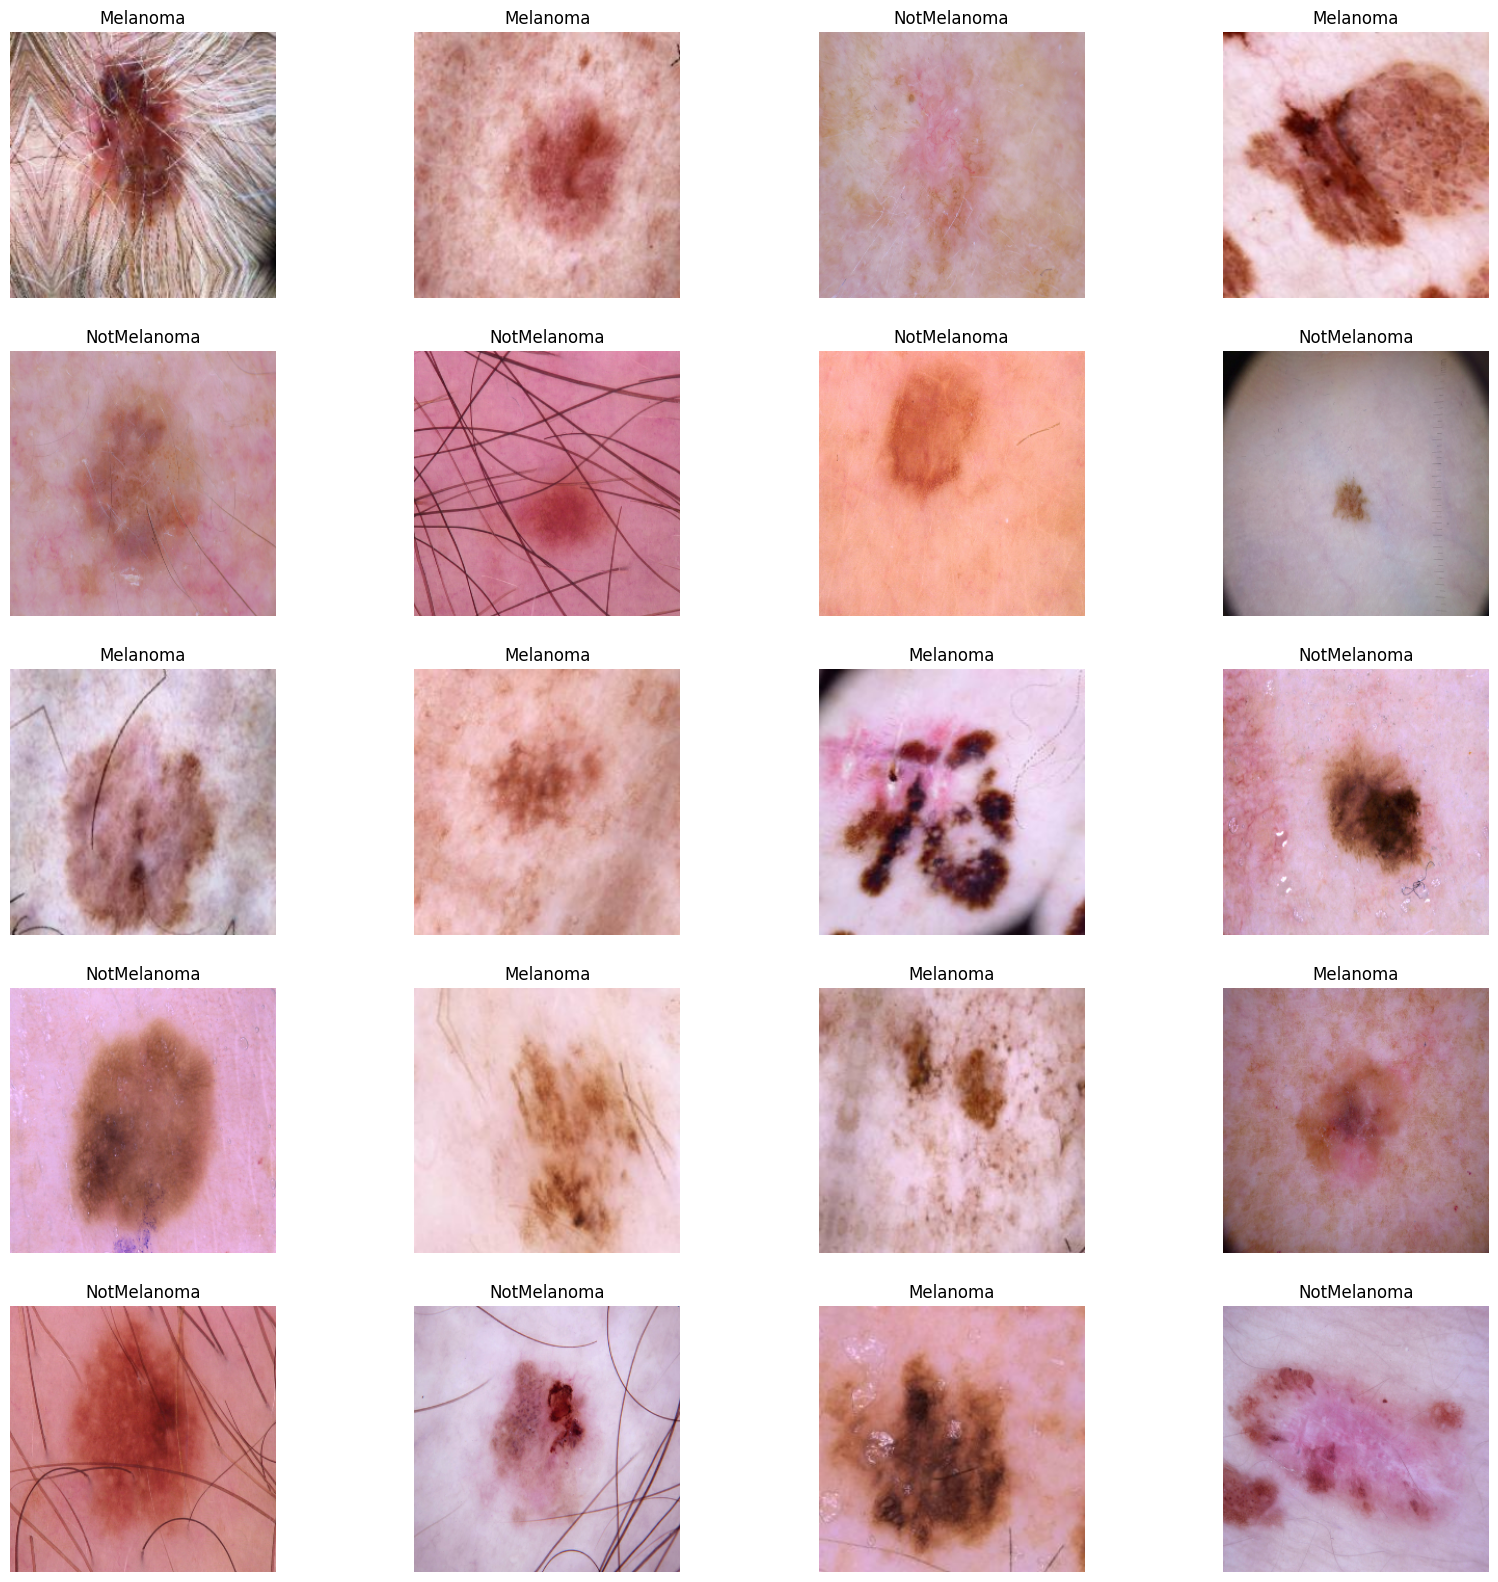

In [10]:
# Visualize some images
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds)

445

In [14]:
len(val_ds)

55

In [15]:
len(test_ds)

57

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
# Data preprocessing and augmentation
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

# Define the model
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape), #32 is for filters and we get this value using trial and error method.
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'), # relu is very fast to compute.
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)), #use to reduce the size of image
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),   #these things using trial and error method
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [21]:
# 184202- no of weights

In [22]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)  # use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [23]:
# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
445/445 [==============================] - 1208s 2s/step - loss: 0.5514 - accuracy: 0.7041 - val_loss: 0.4504 - val_accuracy: 0.7881
Epoch 2/10
445/445 [==============================] - 1053s 2s/step - loss: 0.4508 - accuracy: 0.7857 - val_loss: 0.4031 - val_accuracy: 0.8176
Epoch 3/10
445/445 [==============================] - 1034s 2s/step - loss: 0.4213 - accuracy: 0.8033 - val_loss: 0.3842 - val_accuracy: 0.8364
Epoch 4/10
445/445 [==============================] - 1032s 2s/step - loss: 0.3981 - accuracy: 0.8169 - val_loss: 0.3678 - val_accuracy: 0.8415
Epoch 5/10
445/445 [==============================] - 848s 2s/step - loss: 0.3965 - accuracy: 0.8194 - val_loss: 0.3829 - val_accuracy: 0.8318
Epoch 6/10
445/445 [==============================] - 706s 2s/step - loss: 0.3818 - accuracy: 0.8295 - val_loss: 0.3379 - val_accuracy: 0.8500
Epoch 7/10
445/445 [==============================] - 732s 2s/step - loss: 0.3647 - accuracy: 0.8395 - val_loss: 0.3331 - val_accuracy: 0.

In [24]:
scores = model.evaluate(test_ds)

57/57 [==============================] - 115s 603ms/step - loss: 0.3595 - accuracy: 0.8377


In [25]:
scores   #Scores is just a list containing loss and accuracy value

[0.3594905436038971, 0.8377193212509155]

In [27]:
# Evaluate the model
#scores = model.evaluate(validation_generator)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

Test loss: 0.3594905436038971
Test accuracy: 0.8377193212509155


In [28]:
history


In [29]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 445}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
type(history.history['loss'])

list

In [32]:
len(history.history['loss'])

10

In [33]:
history.history['loss'][:3] # show loss for first 5 epochs

[0.5513577461242676, 0.45084694027900696, 0.42128443717956543]

In [34]:
history.history['loss']

[0.5513577461242676,
 0.45084694027900696,
 0.42128443717956543,
 0.3980729579925537,
 0.39651039242744446,
 0.38182735443115234,
 0.36471089720726013,
 0.3528105616569519,
 0.35459062457084656,
 0.34152141213417053]

In [35]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

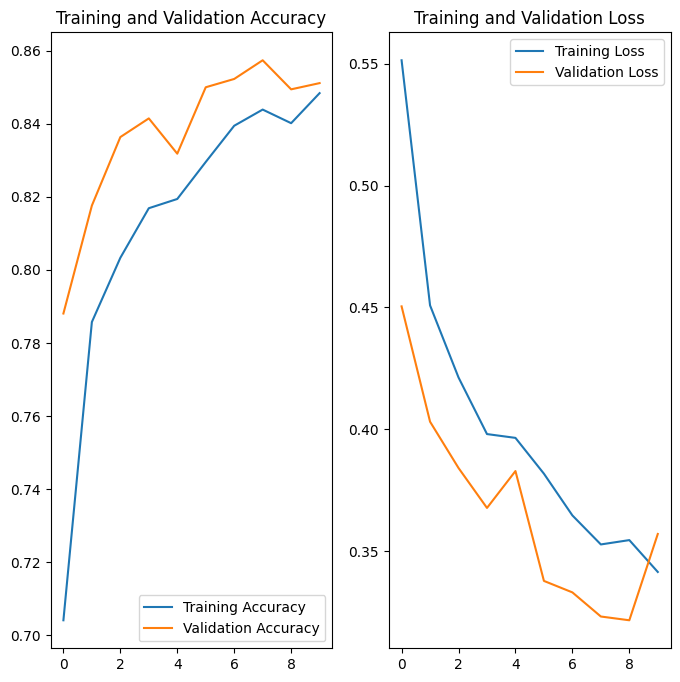

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Melanoma
1/1 [==============================] - 1s 617ms/step
predicted label: Melanoma


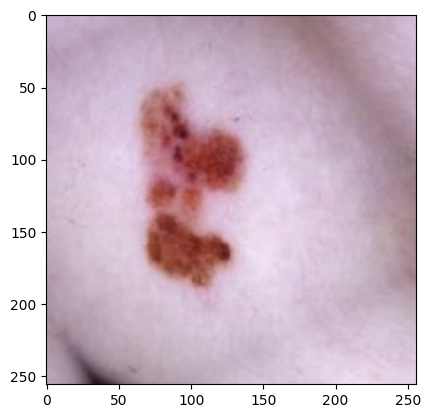

In [38]:
# Make predictions
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 73ms/step


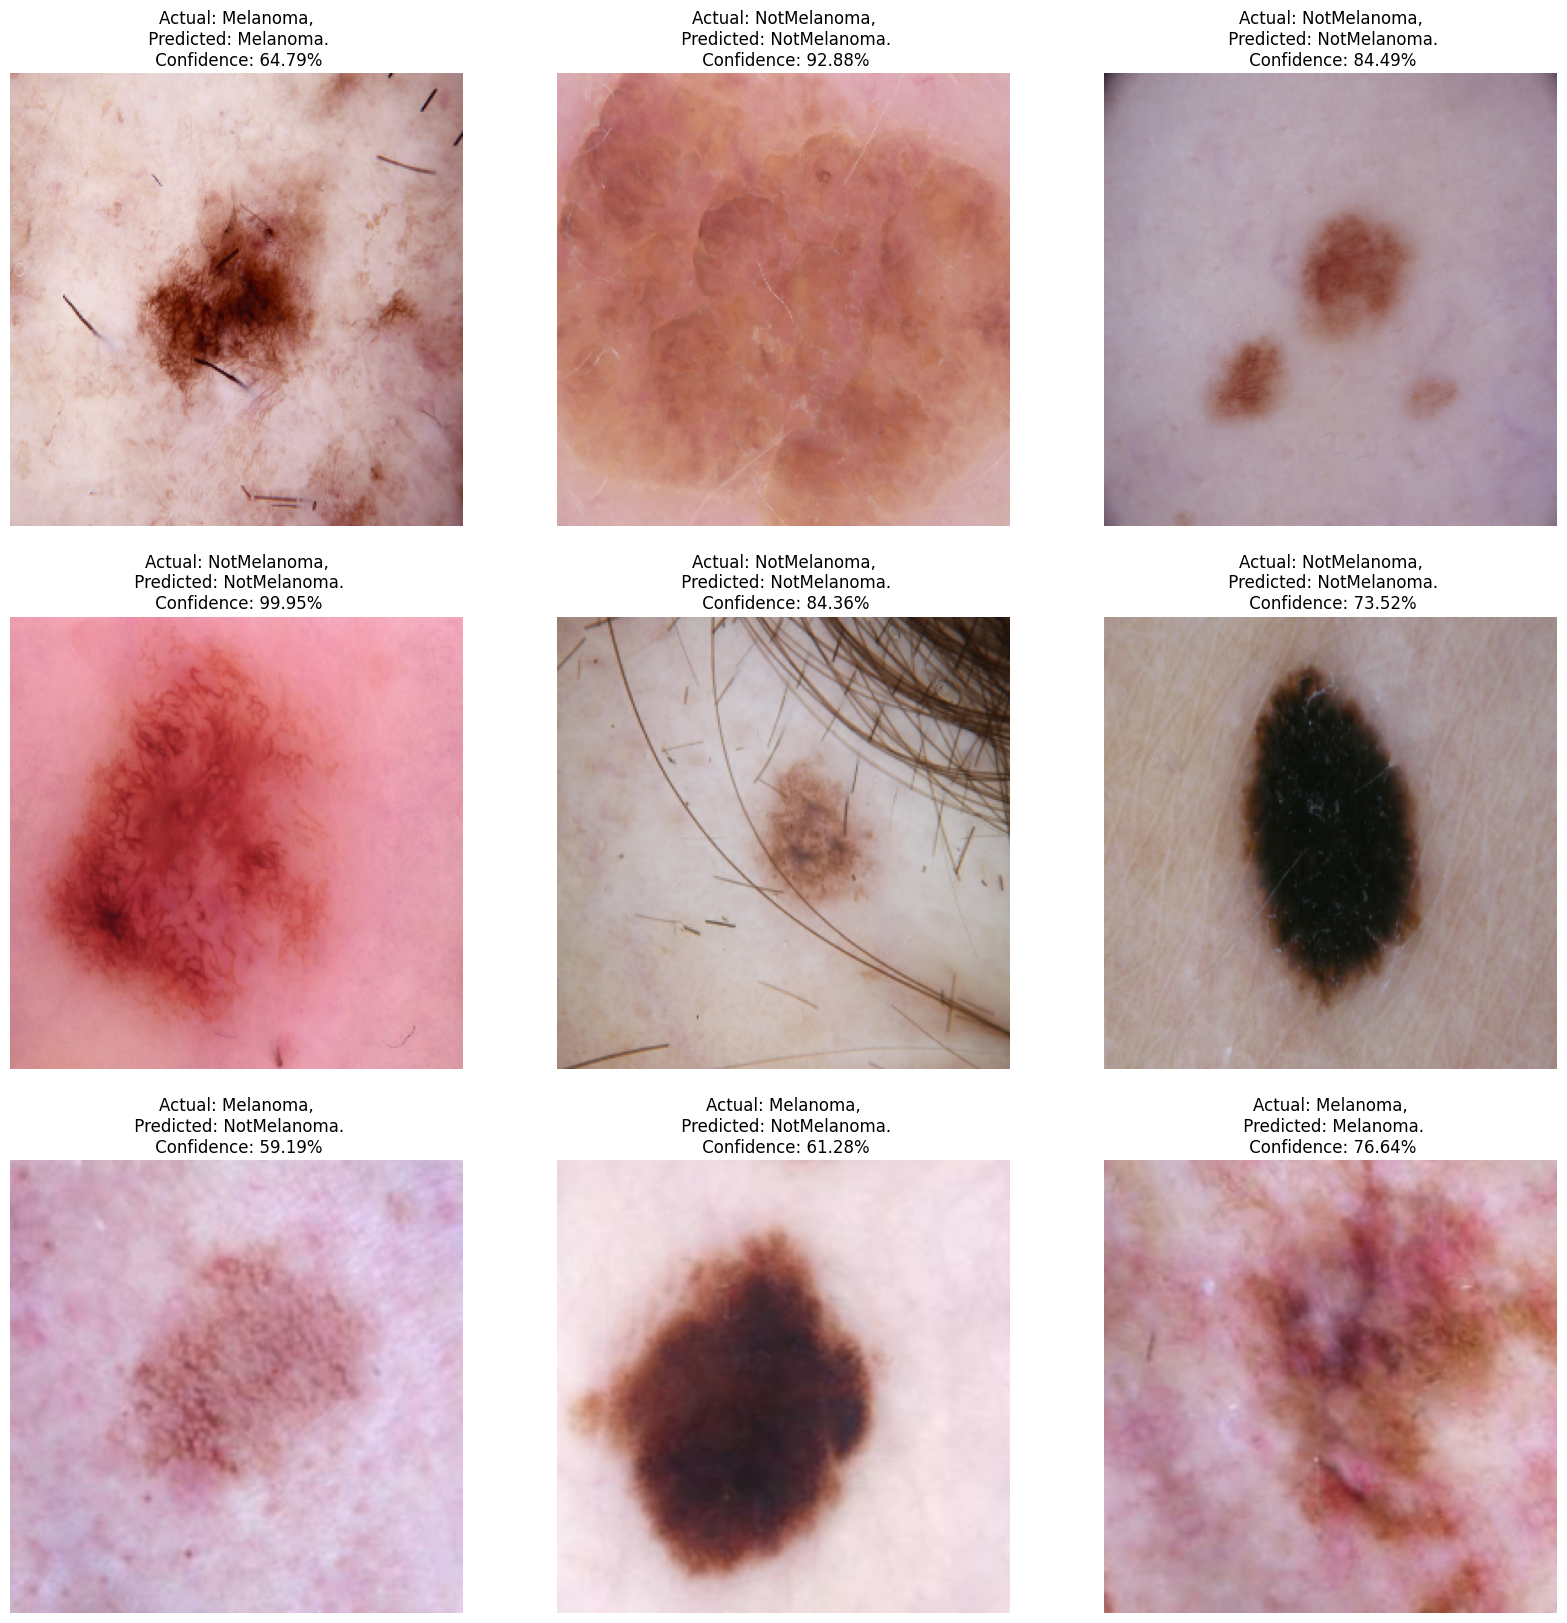

In [40]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [41]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/5\assets


INFO:tensorflow:Assets written to: ../models/5\assets


In [42]:
model.save("../skin_cancer.h5")

C:\Users\ACER\.conda\envs\AI\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/6\assets


INFO:tensorflow:Assets written to: ../models/6\assets
